Inspired from https://www.kaggle.com/soham1024/titanic-data-science-eda-with-meme-solution 

# Part 1. EDA

In [45]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [46]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

In [47]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## Load dataset
- Survived : 생존여부(0: 사망, 1: 생존)
- Pclass : 등실의 등급(1: 1등급, 2: 2등급, 3: 3등급)
- Name : 이름
- Sex : 성별
- Age : 나이
- SibSp : 함께 탑승한 형제자매, 아내 남편의 수
- Parch: 함께 탑승한 부모, 자식의 수
- Ticket: 티켓번호
- Fare: 티켓의 요금
- Cabin: 객실번호
- Embarked: 승선한 위치(C = Cherbourg, Q = Queenstown, S = Southampton)

In [48]:
data_dir = Path('C:\DACON\/titanic\dataset')
sub_dir = Path('C:\DACON\titanic\/build')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'submission.csv'

seed = 23

In [49]:
# algo_name = 'lgb'
# feature_name = 'feature'
# model_name = f'{algo_name}_{feature_name}'

# # feature_file = feature_dir / f'{feature_name}.csv'
# sub_file = sub_dir / f'{model_name}.csv'
# print(sub_file)

In [50]:
trn = pd.read_csv(trn_file, index_col=0)
tst = pd.read_csv(tst_file, index_col=0)

# 앞의 값으로 결측치 채우기
# trn = trn.fillna(method='ffill')
# tst = tst.fillna(method='ffill')
target_col = 'Survived'
feature_name = trn.columns.tolist()
print(feature_name)
old_features = []
new_features = []

print(trn.shape, tst.shape)
trn.head()

['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
(891, 11) (418, 10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA
**Assumptions.**
- People who are likely to survive:
  1. Women (Sex=female)
  2. Children (Age<X) 
  3. Upper-class (Pclass=1)


In [51]:
trn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


**Observations.**
- Train dataset: Age에서 177개, Cabin에서 687개, Embarked에서 2개 결측치 확인

In [52]:
trn.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.0000,891.0000,714.0000,891.0000,891.0000,891.0000
mean,0.3838,2.3086,29.6991,0.5230,0.3816,32.2042
std,0.4866,0.8361,14.5265,1.1027,0.8061,49.6934
min,0.0000,1.0000,0.4200,0.0000,0.0000,0.0000
25%,0.0000,2.0000,20.1250,0.0000,0.0000,7.9104
50%,0.0000,3.0000,28.0000,0.0000,0.0000,14.4542
75%,1.0000,3.0000,38.0000,1.0000,0.0000,31.0000
max,1.0000,3.0000,80.0000,8.0000,6.0000,512.3292


In [53]:
trn.describe(include='O') # object type

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


## 'Sex'

In [54]:
trn[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.7420
1,male,0.1889


**Observations.**
- 여성(Sex=female)의 생존율이 더 높음

**Decisions.**
- model train 할 때, **'Sex'** 사용할 것

## 'Pclass'

In [55]:
print(trn[['Pclass', 'Survived']].corr())
print('-'*30)
trn[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

          Pclass  Survived
Pclass    1.0000   -0.3385
Survived -0.3385    1.0000
------------------------------


,Pclass,Survived
0,1,0.6296
1,2,0.4728
2,3,0.2424


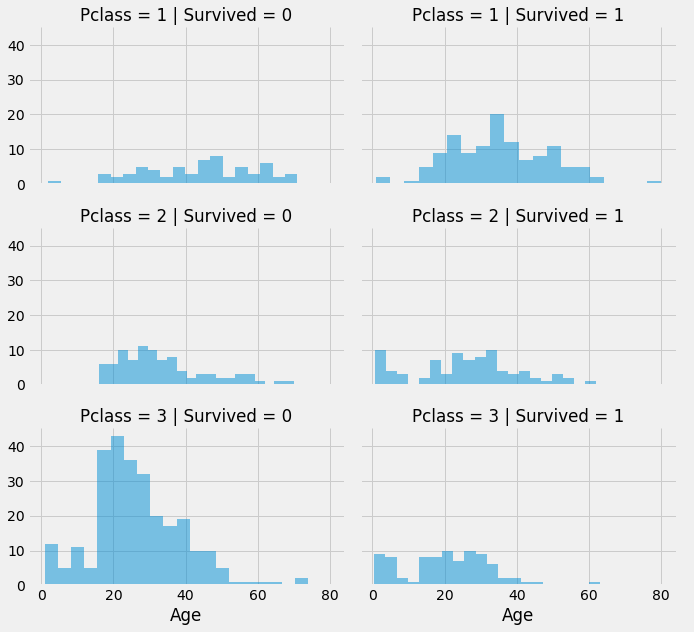

In [56]:
grid = sns.FacetGrid(trn, col='Survived', row='Pclass', size=3, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

**Observations.**
- corr() 함수로 관계성을 계산하기보다는 그룹별로 Survived의 평균을 확인하는 것이 더 효과적
- Pclass 값이 작을수록 생존율이 더 높음

**Decisions.**
- model train 할 때, **'Pclass'** 사용할 것 

## 'Embarked' with 'Pclass', 'Sex', 'Fare'

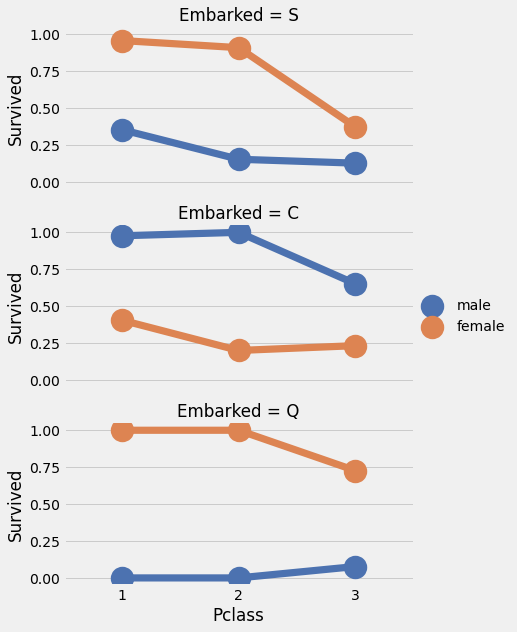

In [57]:
grid = sns.FacetGrid(trn, row='Embarked', size=3, aspect=2)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', ci= .5)
grid.add_legend()

**Observations.**
- Embarked = S, Q에서는 female의 생존율이 높고, Embarked = C에서는 male의 생존율이 높음

**Decisions.**
- model train할 때, **'Embarked'** 사용할 것

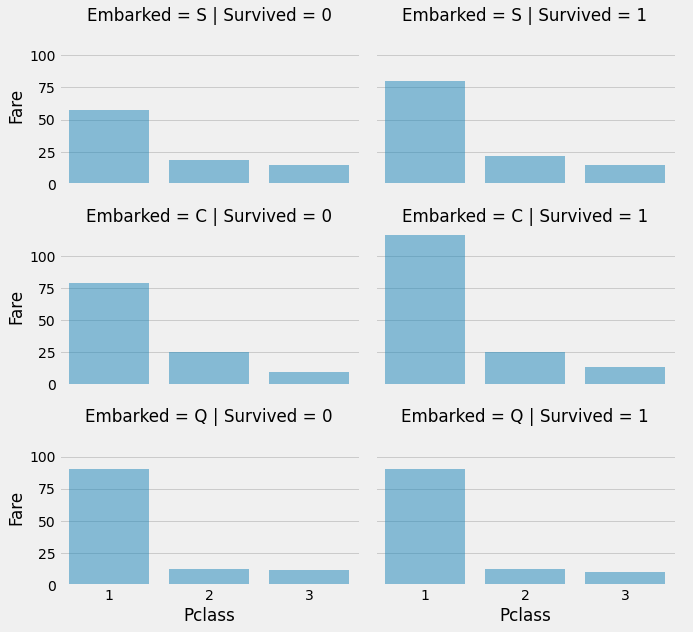

In [58]:
grid = sns.FacetGrid(trn, row='Embarked', col='Survived', size=3, aspect=1.6)
grid.map(sns.barplot, 'Pclass', 'Fare', alpha=.5, ci=None)  # plot mean Fare
grid.add_legend()

**Observations.**
- Embarked, Pclass를 동일하게 놓고 비교했을 때, Survived = 1 그룹의 평균 Fare가 더 높음

**Decisions.**
- model train할 때, **'Fare'** 사용할 것

## 'Age' with 'Parch', 'SibSp'

Text(0, 0.5, 'Parch(dark) and SibSp(light)')

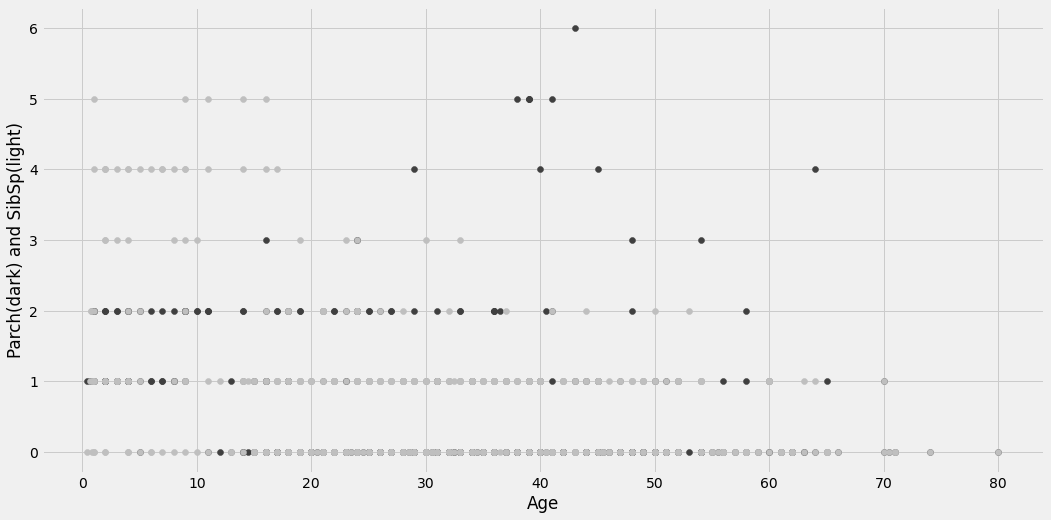

In [59]:
plt.scatter(trn['Age'], trn['Parch'], color='0.25')
plt.scatter(trn['Age'], trn['SibSp'], color='0.75')
plt.xlabel("Age")
plt.ylabel("Parch(dark) and SibSp(light)")

In [60]:
print(trn[['SibSp', 'Parch', 'Age', 'Survived']].corr())
print('-'*30)
trn[["SibSp", "Age"]].groupby(['SibSp'], as_index=False).mean()

           SibSp   Parch     Age  Survived
SibSp     1.0000  0.4148 -0.3082   -0.0353
Parch     0.4148  1.0000 -0.1891    0.0816
Age      -0.3082 -0.1891  1.0000   -0.0772
Survived -0.0353  0.0816 -0.0772    1.0000
------------------------------


,SibSp,Age
0,0,31.3976
1,1,30.0897
2,2,22.6200
3,3,13.9167
4,4,7.0556
5,5,10.2000
6,8,NaN


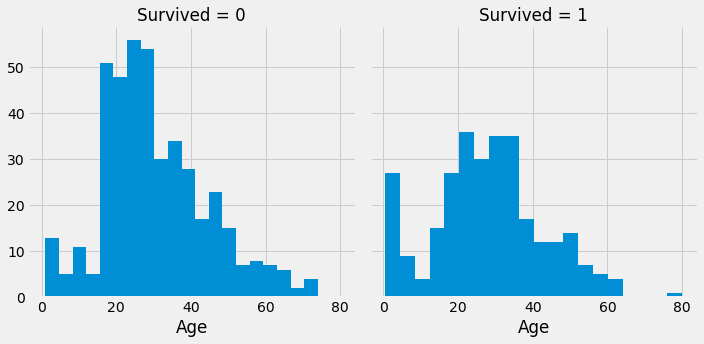

In [61]:
g = sns.FacetGrid(trn, col='Survived', size = 5)
g.map(plt.hist, 'Age', bins=20)

**Observations.**
- 첫번째 그룹(Age<=4)과 마지막 그룹(Age=80)에서 높은 생존율
- 15<=Age<=25에서 낮은 생존율

**Decisions.**
- model train 할 때, **'Age'** 사용할 것
- 'Parch'랑 'SipSp'는 단일 feature로는 의미가 덜하니 가공 필요함